<a href="https://colab.research.google.com/github/cristinarainich/Sternberg_analysis/blob/main/Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import pandas as pd
import numpy as np
from pathlib import Path
import pylab as pl
import seaborn as sns
import re
from scipy import stats
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [5]:
sns.set()

In [40]:
!pip install -q pymer4

In [41]:
from pymer4.models import Lmer

In [57]:
!pip install -q statsmodels

In [58]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Uploading data

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
working_path = Path('/content/drive/MyDrive/CoganLab')

In [7]:
ieeg = pd.read_csv(
    working_path.joinpath('ieeg_no_outliers.csv'),
    index_col=None
)

In [8]:
eeg = pd.read_csv(
    working_path.joinpath('eeg_no_outliers.csv'),
    index_col=None
)

## EEG dataset

In [12]:
eeg_data = eeg[[
                'Trial', 'Subject', 'Block',
                'ProbeType', 'stdRT', 'ResponseCorrect',
                'Position', 'Length', 'Lex', 'Phono'
]]

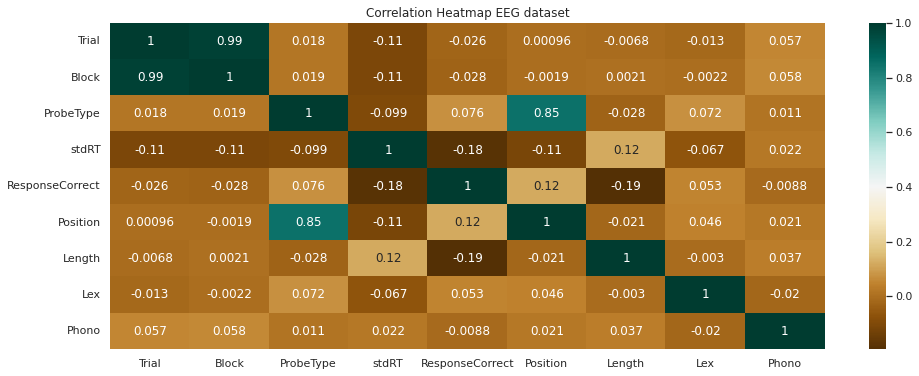

In [22]:
pl.figure(figsize=(16, 6))
map = sns.heatmap(eeg_data.corr(), annot=True, cmap = 'BrBG')
map.set_title('Correlation Heatmap EEG dataset');

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


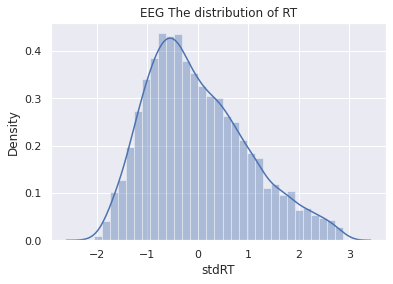

In [21]:
sns.distplot(eeg_data.stdRT)
pl.title('EEG The distribution of RT');

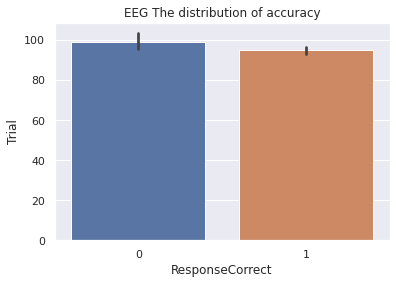

In [20]:
sns.barplot(
    x = 'ResponseCorrect', y = 'Trial',
    data = eeg_data
    )
pl.title('EEG The distribution of accuracy');

In [29]:
eeg_data.head()

,Trial,Subject,Block,ProbeType,stdRT,ResponseCorrect,Position,Length,Lex,Phono
0,1,E2,1,2,0.535034,1,3,5,0,1
1,2,E2,1,2,-0.366749,1,3,9,1,1
2,3,E2,1,2,1.474424,1,1,5,1,0
3,4,E2,1,1,0.234390,1,0,7,0,0
4,5,E2,1,2,1.405773,1,1,9,0,0


In [59]:
# Run LMER
model = smf.mixedlm(
    "stdRT ~ Lex", 
    data = eeg_data, 
    groups=eeg_data["Subject"], 
    re_formula="~Lex")

In [60]:
mdf = model.fit(method=["lbfgs"])
print(mdf.summary())

          Mixed Linear Model Regression Results
Model:              MixedLM Dependent Variable: stdRT     
No. Observations:   5334    Method:             REML      
No. Groups:         29      Scale:              0.6313    
Min. group size:    153     Likelihood:         -6413.3407
Max. group size:    192     Converged:          Yes       
Mean group size:    183.9                                 
----------------------------------------------------------
                Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------
Intercept        0.084    0.114  0.739 0.460 -0.139  0.308
Lex             -0.134    0.022 -6.074 0.000 -0.177 -0.091
Group Var        0.370    0.127                           
Group x Lex Cov  0.011    0.017                           
Lex Var          0.000    0.005                           



/usr/local/lib/python3.7/dist-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [61]:
# Install R and Rpy2
!apt-get install r-base
!pip install -q rpy2

# Install LMER packages (THIS TAKES ABOUT 3~5 minutes)
packnames = ('lme4', 'lmerTest', 'emmeans', "geepack")
from rpy2.robjects.packages import importr
from rpy2.robjects.vectors import StrVector
utils = importr("utils")
utils.chooseCRANmirror(ind=1)
utils.install_packages(StrVector(packnames))

Reading package lists... Done
Building dependency tree       
Reading state information... Done
r-base is already the newest version (4.2.0-1.1804.0).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


<rpy2.rinterface_lib.sexp.NULLType object at 0x7fd1d740cbe0> [RTYPES.NILSXP]

In [62]:
%load_ext rpy2.ipython

In [63]:
%%R 
library(lme4)
library(lmerTest)

In [75]:
eeg_data.head()

,Trial,Subject,Block,ProbeType,stdRT,ResponseCorrect,Position,Length,Lex,Phono
0,1,E2,1,2,0.535034,1,3,5,0,1
1,2,E2,1,2,-0.366749,1,3,9,1,1
2,3,E2,1,2,1.474424,1,1,5,1,0
3,4,E2,1,1,0.234390,1,0,7,0,0
4,5,E2,1,2,1.405773,1,1,9,0,0


In [88]:
model = Lmer(
    'stdRT ~ Lex + (1|Subject)', 
    data=eeg_data
    )

In [89]:
model.fit()

Formula: stdRT~Lex+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 5334	 Groups: {'Subject': 29.0}

Log-likelihood: -6413.693 	 AIC: 12827.386

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.382  0.618
Residual               0.631  0.795

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),0.085,-0.142,0.311,0.116,28.501,0.731,0.471,
Lex,-0.135,-0.177,-0.092,0.022,5304.011,-6.185,0.000,***


In [90]:
0.382 / (0.382+0.631)

0.3770977295162883

## iEEG dataset

In [24]:
ieeg_data = ieeg[[
                'Trial', 'Subject', 'block',
                'ProbeType', 'stdRT', 'RespCorrect',
                'Position', 'Length', 'Lex', 'Phono'  
]]

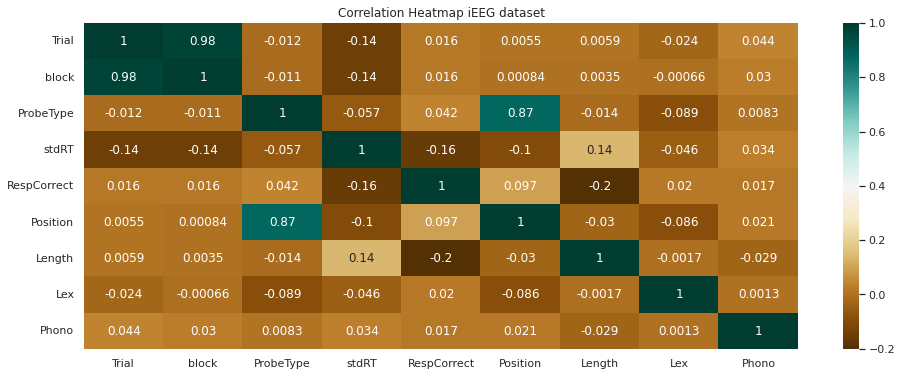

In [25]:
pl.figure(figsize=(16, 6))
map = sns.heatmap(ieeg_data.corr(), annot=True, cmap = 'BrBG')
map.set_title('Correlation Heatmap iEEG dataset');

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


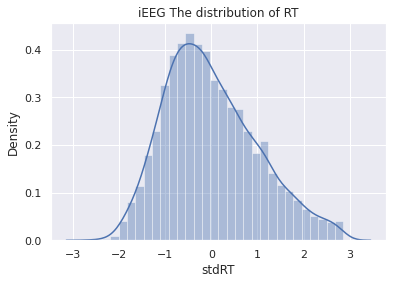

In [26]:
sns.distplot(ieeg_data.stdRT)
pl.title('iEEG The distribution of RT');

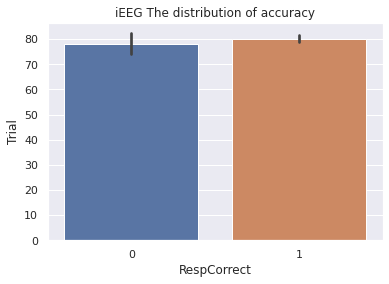

In [28]:
sns.barplot(
    x = 'RespCorrect', y = 'Trial',
    data = ieeg_data
    )
pl.title('iEEG The distribution of accuracy');